# Instrumental folder generation for CMWP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from src.xrd_tools import getReflections
from lmfit import fit_report
from lmfit.models import LinearModel,  PseudoVoigtModel, Pearson7Model, GaussianModel, SkewedVoigtModel, SkewedGaussianModel
from scipy.interpolate import CubicSpline

%matplotlib inline

## Set paramaters

In [105]:
a = 4.15691                   # a lattice paramater of the calibrant in angstrom             
wavelength = 1.5406           # Wavelength in angstrom
removefirst = 0             # Remove first x points
fittype = 'pseudovoigt'           # Fit method: 'pseudovoigt or pearson'
weight = 'none'            # Weight method: 'none, sqrt or invsqrt'

inputfile = '/home/rhys/Dropbox (Research Group)/XRD/2023_03_EP_test/LaB6_NIST660c-CuKa1-BB-SSopen-IS0.4-Lcoll0.8-air-sc-pr-RS2_38.5-2Dh-eta176-184-1Dconv.dat'   # input file, two columns, 2theta and intensity
outfolder = '/home/rhys/Desktop/lab6_mrf/lab6_johansson'                                               # export folder

#inputfile = '/home/rhys/Dropbox (Research Group)/XRD/2023_03_EP_test/LaB6_NIST660c-Cu-PB-Ge220x2-SSopen-IS0.1-Lcoll0.8-air-sc-pr-2Dvsc-eta-176-184-1Dconv.dat'   # input file, two columns, 2theta and intensity
#outfolder = '/home/rhys/Desktop/lab6_mrf/lab6_doublebounce'                                               # export folder

In [106]:
x_2theta, y, _, _ = np.loadtxt(inputfile, unpack=True)
y=y+100
x_2theta=x_2theta[removefirst:]; y=y[removefirst:];

x_k_nm = 10 * 2 * np.sin(np.deg2rad(np.array(x_2theta)/2)) / wavelength

In [107]:
peak_name, peak_pos = getReflections(crystalType='cubic', outputType='2theta', a=a, wavelength=wavelength, printReflections=False)
_, peak_pos_k = getReflections(crystalType='cubic', outputType='k', a=a, wavelength=wavelength, printReflections=False)
peak_pos_k_nm = peak_pos_k*10

peak_pos_k_nm = peak_pos_k_nm[peak_pos_k_nm < np.max(x_k_nm)]
peak_pos_k_nm = peak_pos_k_nm[peak_pos_k_nm > np.min(x_k_nm)]

baseline = np.array(x_k_nm[30])
baseline = np.append(baseline, (peak_pos_k_nm[:-1]+peak_pos_k_nm[1:])/2)
baseline = np.append(baseline, x_k_nm[-30])


In [108]:
print('The following peaks are used:')
print(peak_pos_k_nm)

The following peaks are used:
[ 2.40563303  3.40207886  4.16667863  4.81126606  5.37915898  5.89257343
  6.80415772  7.21689909  7.60727959  7.97858214  8.33335727  8.67363324
  9.0010546   9.62253212  9.91867908 10.20623657 10.48591127 10.75831797
 11.02399546 11.28341908]


In [109]:
print('Baseline is based on the following K values:')
print(baseline)

Baseline is based on the following K values:
[ 2.12029031  2.90385594  3.78437875  4.48897235  5.09521252  5.63586621
  6.34836557  7.0105284   7.41208934  7.79293087  8.15596971  8.50349525
  8.83734392  9.31179336  9.7706056  10.06245783 10.34607392 10.62211462
 10.89115671 11.15370727 11.59057218]


## Subtract background

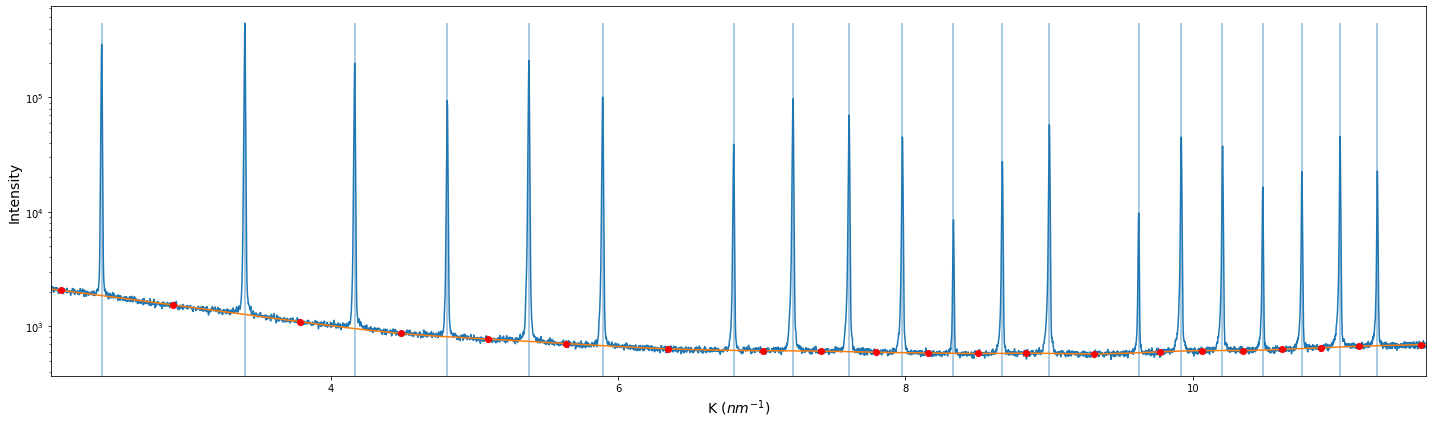

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(20,6))
ax.vlines(peak_pos_k_nm, ymin=0, ymax=np.max(y), alpha=0.5)
ax.plot(x_k_nm, y, '-')
ax.set_xlabel('K ($nm^{-1}$)', fontsize=14); ax.set_ylabel('Intensity', fontsize=14);
ax.set_xlim(np.min(x_k_nm), np.max(x_k_nm))
ax.set_yscale('log')

plt.tight_layout()
baseline_int=[]

for j in baseline:
    num_index =np.argmin(np.abs(x_k_nm-j))
    baseline_int.append(np.mean(y[num_index-15:num_index+15]))
        
cs = CubicSpline(baseline, baseline_int)

ax.plot(x_k_nm, cs(x_k_nm))
ax.plot(baseline, baseline_int, c='r', marker='o', linewidth=0)

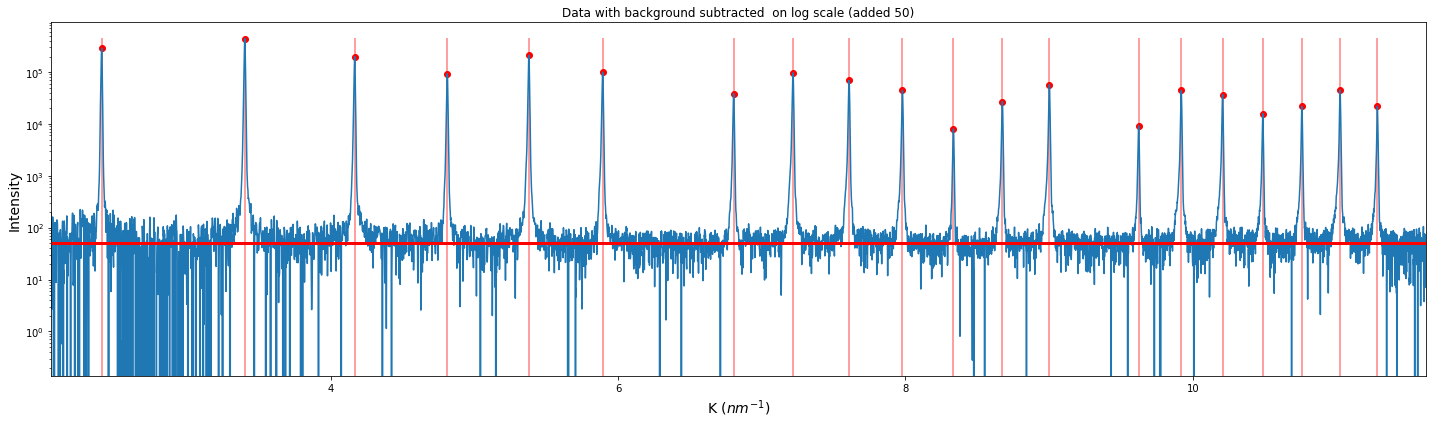

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(20,6))

y_nobck = y-cs(x_k_nm)

ax.plot(x_k_nm, y_nobck+50, '-')
ax.set_xlabel('K ($nm^{-1}$)', fontsize=14); ax.set_ylabel('Intensity', fontsize=14);
ax.set_xlim(np.min(x_k_nm), np.max(x_k_nm))
ax.set_yscale('log')
ax.hlines([50], colors='r', linewidth=3, xmin=np.min(x_k_nm), xmax=np.max(x_k_nm), zorder=20)
plt.title('Data with background subtracted  on log scale (added 50)')

actual_peaks = []

for i, peak in enumerate(peak_pos_k_nm):
        
    searchrange = 10

    elem = np.abs(x_k_nm-peak).argmin()

    peak_index = np.argmax(y_nobck[elem-searchrange:elem+searchrange])+elem-searchrange
    peak_x = x_k_nm[peak_index]
    actual_peaks.append(peak_x)

    ax.scatter(peak_x, y_nobck[peak_index]+50, c='r')
        
ax.vlines(actual_peaks, ymin=0, ymax=np.max(y), alpha=0.5, color='red')

plt.tight_layout()


## Fit peaks

/home/rhys/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: FutureWarning: The input object of type 'Parameters' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Parameters', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/rhys/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwar

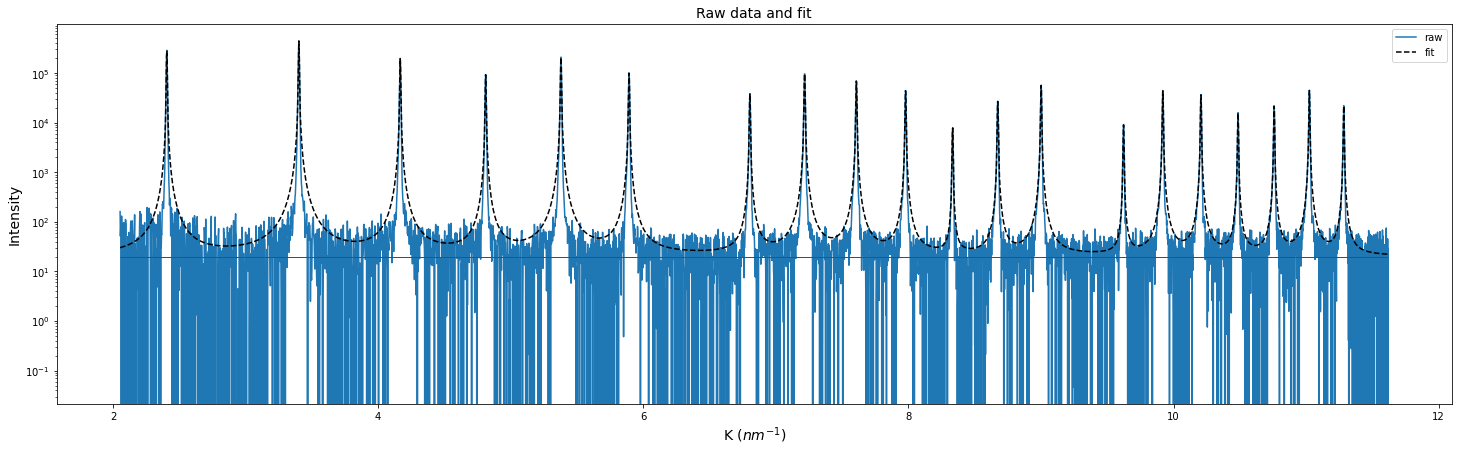

In [112]:
models = []; pars = []; prefixes = [];

for i, peak in enumerate(actual_peaks):
        
    search = 20 + i*10

    elem = np.abs(x_k_nm-peak).argmin()

    xvals = x_k_nm[elem-search:elem+search]
    yvals = y_nobck[elem-search:elem+search]
    
    prefix = 'g'+str(i)+'_'
    prefixes.append(prefix)
    
    if fittype == 'pseudovoigt':
        mod = PseudoVoigtModel(prefix=prefix)
        models.append(mod)

        par = mod.make_params()

        par[prefix+'fraction'].set(value=0.5, min=0, max=1)
        
    elif fittype == 'pearson':
        mod = Pearson7Model(prefix=prefix, nan_policy='omit')
        models.append(mod)

        par = mod.make_params()

    par[prefix+'center'].set(value=peak, min=peak-0.05, max=peak+0.05)
    par[prefix+'sigma'].set(value=0.002, min=0.001, max=0.1)
    par[prefix+'height'].set(value=(np.max(yvals)-np.min(yvals)), min=(np.max(yvals)-np.min(yvals))-100, max=(np.max(yvals)-np.min(yvals))+100)
    pars.append(par)

models = np.sum(models)
pars = np.sum(pars)
    
init = models.eval(pars, x=x_k_nm)

addon = 0

if weight == 'none':
    out = models.fit(y_nobck+addon, pars, x=x_k_nm)
elif weight == 'invsqrt':
    out = models.fit(y_nobck+addon, pars, weights=1/np.sqrt(np.abs(y_nobck)+1), x=x_k_nm)
elif weight == 'sqrt':
    out = models.fit(y_nobck+addon, pars, weights=np.sqrt(np.abs(y_nobck)+1), x=x_k_nm)

elevate = 20
fig, ax = plt.subplots(1,1, figsize=(25, 7))
ax.plot(x_k_nm, y_nobck+elevate+addon, label='raw')
ax.plot(x_k_nm, np.sum([out.eval_components(x=x_k_nm)[prefix] for prefix in prefixes], axis=0)+elevate, 'k--', label='fit')
ax.legend()

ax.set_title('Raw data and fit', fontsize=14)
ax.set_xlabel('K ($nm^{-1}$)', fontsize=14); ax.set_ylabel('Intensity', fontsize=14);

ax.hlines([elevate], colors='r', linewidth=1, xmin=np.min(x_k_nm), xmax=np.max(x_k_nm), zorder=20)

ax.set_yscale('log')

## Show individual components, normalised by height

In [115]:
sigmas = []; centers = [];

if fittype == 'pseudovoigt': 
    for prefix in prefixes:
        print('Prefix: {0}\tCenter: {1:.3f}\tHeight: {2:.0f}\tFWHM: {3:.5f}\tFraction: {4:.2f}'.
          format(prefix, 
                 out.result.params[prefix+'center'].value, 
                 out.result.params[prefix+'height'].value,
                 out.result.params[prefix+'fwhm'].value,
                 out.result.params[prefix+'fraction'].value))
        sigmas.append(out.result.params[prefix+'fwhm'].value)
        centers.append(out.result.params[prefix+'center'].value)     
        
elif fittype == 'pearson':
    for prefix in prefixes:
        print('Prefix: {0}\tCenter: {1:.3f}\tHeight: {2:.0f}\tFWHM: {3:.5f}'.
          format(prefix, 
                 out.result.params[prefix+'center'].value, 
                 out.result.params[prefix+'height'].value,
                 out.result.params[prefix+'fwhm'].value))
        sigmas.append(out.result.params[prefix+'fwhm'].value)
        centers.append(out.result.params[prefix+'center'].value)

Prefix: g0_	Center: 2.406	Height: 288067	FWHM: 0.00669	Fraction: 0.43
Prefix: g1_	Center: 3.402	Height: 443913	FWHM: 0.00678	Fraction: 0.45
Prefix: g2_	Center: 4.166	Height: 197958	FWHM: 0.00648	Fraction: 0.57
Prefix: g3_	Center: 4.811	Height: 92956	FWHM: 0.00662	Fraction: 0.56
Prefix: g4_	Center: 5.379	Height: 210197	FWHM: 0.00667	Fraction: 0.59
Prefix: g5_	Center: 5.892	Height: 100029	FWHM: 0.00703	Fraction: 0.53
Prefix: g6_	Center: 6.804	Height: 38424	FWHM: 0.00701	Fraction: 0.55
Prefix: g7_	Center: 7.217	Height: 96727	FWHM: 0.00715	Fraction: 0.53
Prefix: g8_	Center: 7.607	Height: 69251	FWHM: 0.00699	Fraction: 0.57
Prefix: g9_	Center: 7.979	Height: 44595	FWHM: 0.00702	Fraction: 0.55
Prefix: g10_	Center: 8.334	Height: 7979	FWHM: 0.00723	Fraction: 0.46
Prefix: g11_	Center: 8.674	Height: 27030	FWHM: 0.00712	Fraction: 0.50
Prefix: g12_	Center: 9.001	Height: 57173	FWHM: 0.00697	Fraction: 0.54
Prefix: g13_	Center: 9.623	Height: 9227	FWHM: 0.00681	Fraction: 0.52
Prefix: g14_	Center: 9.919	

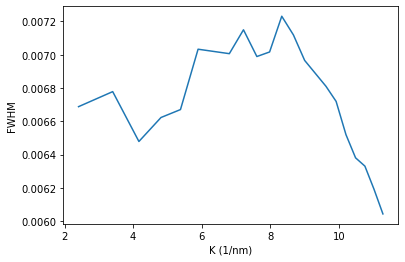

In [116]:
fig, ax = plt.subplots()

ax.plot(centers,sigmas)
ax.set_xlabel('K (1/nm)');
ax.set_ylabel('FWHM');


In [91]:
# Expand d range to catch peaks that are clipping on edges

gap=x_2theta[1]-x_2theta[0]
new_x_2theta = np.arange(np.min(x_2theta)-0.2, np.max(x_2theta)+0.2, gap)
new_x_k_nm = 10 * 2 * np.sin(np.deg2rad(np.array(new_x_2theta)/2)) / wavelength

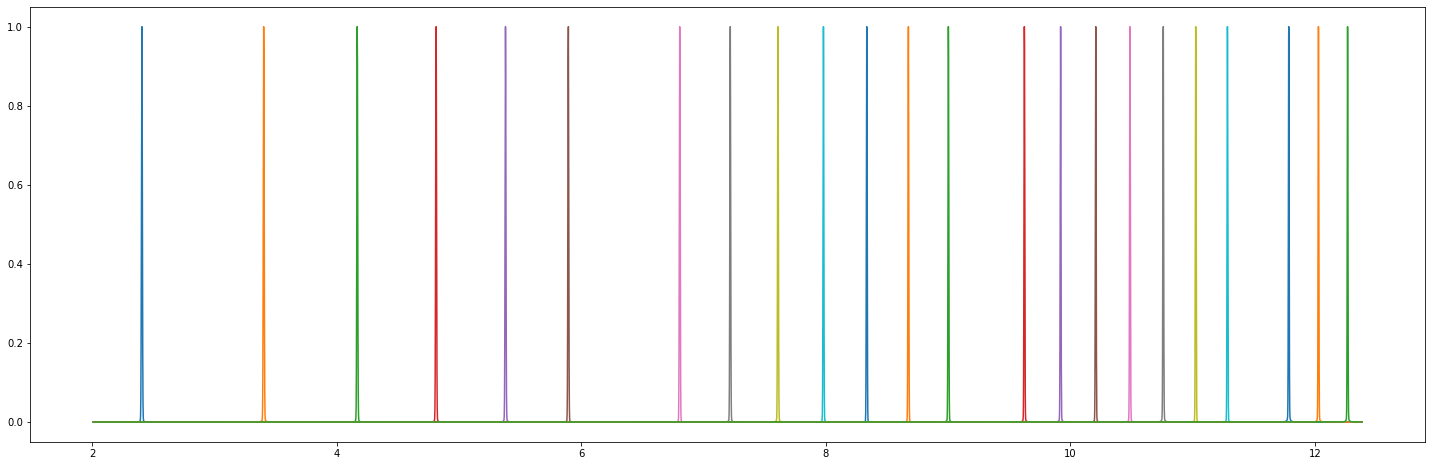

In [92]:
maxheight = np.max([out.eval_components(x=x_k_nm)[prefix] for prefix in prefixes])
fig, ax = plt.subplots(figsize=(25,8))
for prefix in prefixes:
    scale_height = 1/np.max(out.eval_components(x=new_x_k_nm)[prefix])
    ax.plot(new_x_k_nm, out.eval_components(x=new_x_k_nm)[prefix]*scale_height, label='fit')
    #print(out.params[prefix + 'sigma'].value)
#plt.yscale('log')
#plt.ylim(-20, 1000)

## Save instrumental folder

### Use the fitted peaks from above

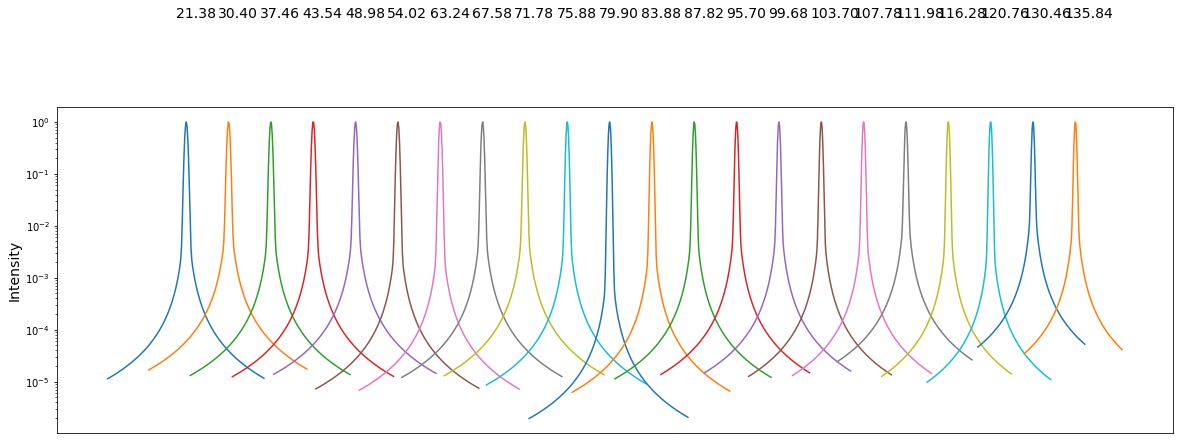

In [93]:
if not os.path.exists(outfolder):
    os.makedirs(outfolder)
    
fig, ax = plt.subplots(figsize=(20,6))

for i, prefix in enumerate(prefixes[:-1]):
    
    search = 100 + (3 * i)
    
    y_out = out.eval_components(x=new_x_k_nm)[prefix]
    
    elem = y_out.argmax()

    xvals = new_x_k_nm[elem-search:elem+search]
    yvals = y_out[elem-search:elem+search]/np.max(y_out[elem-search:elem+search])
    
    xvals = xvals - out.result.params[prefix+'center'].value

    peak_k = new_x_k_nm[elem]
    
    peak_2th = np.rad2deg(np.arcsin((peak_k * wavelength) / 20))*2
    

    np.savetxt(outfolder + '/' + '{0:.3f}'.format(peak_2th), np.array([xvals, yvals]).T, fmt = ('%1.8f'))

    ax.plot(xvals+i*0.12, yvals)
    ax.set_ylabel('Intensity', fontsize=14);
    ax.get_xaxis().set_visible(False)

    ax.text(x=i*0.12-0.03, y=np.max(yvals)+100, s='{0:.2f}'.format(peak_2th), fontsize=14)

    plt.yscale('log')


## Use the raw data instead

In [94]:
if not os.path.exists(outfolder+'_raw'):
    os.makedirs(outfolder+'_raw')

for i, prefix in enumerate(prefixes[:-1]):
    
    search = 80
    
    y_out = out.eval_components(x=new_x_k_nm)[prefix]
    
    elem = y_out.argmax()
    peaki = np.argmin(np.abs(x_k_nm-out.result.params[prefix+'center'].value))
    
    yvals = y_nobck[peaki-search:peaki+search]/np.max(y_nobck[peaki-search:peaki+search])
    xvals= x_k_nm[peaki-search:peaki+search]
    
    xvals = xvals - out.result.params[prefix+'center'].value

    peak_k = new_x_k_nm[elem]
    
    peak_2th = np.rad2deg(np.arcsin((peak_k * wavelength) / 20))*2
    
    np.savetxt(outfolder+'_raw' + '/' + '{0:.3f}'.format(peak_2th), np.array([xvals, yvals]).T, fmt = ('%1.8f'))
    